In [3]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

%matplotlib inline

# 1. Visualization

## 1.1 Wave and spectrogram

In [7]:
import py7zr

with py7zr.SevenZipFile('train.7z', mode='r') as z:
    z.extractall()
    
with py7zr.SevenZipFile('test.7z', mode='r') as z:
    z.extractall()

In [9]:
train_audio_path = 'train/audio/'
filename = '/yes/0a7c2a8d_nohash_0.wav'
sample_rate, samples = wavfile.read(str(train_audio_path) + filename)

In [10]:
def log_specgram(audio, sample_rate, window_size=20, step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    # signal.spectrogram 함수를 사용하여 audio 시계열 데이터를 주파수 영역으로 변환
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps) # 변환된 주파수 영역을 로그 스케일로 변환

Nyquist theorem에 따르면 주파수는 (0, 8000) 범위에 있다.

Text(0.5, 0, 'Seconds')

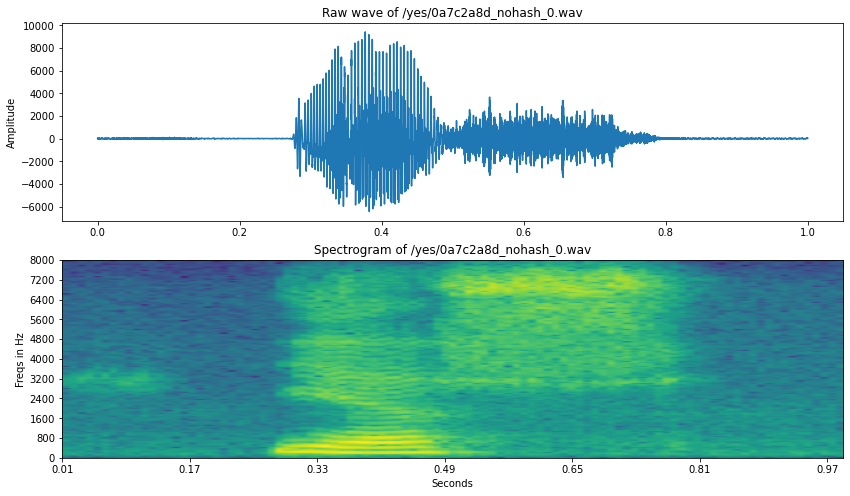

In [11]:
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [12]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

## 1.2 MFCC

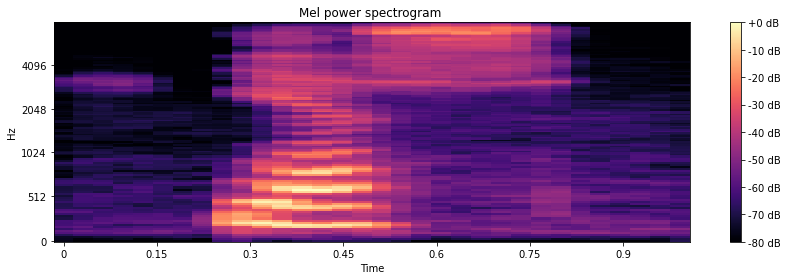

In [15]:
samples = samples.astype(float)

# S = librosa.feature.melspectrogram(samples, sr=sample_rate, n_mels=128)  
S = librosa.feature.melspectrogram(y=samples, sr=sample_rate, n_mels=128) # 입력된 음성 데이터(samples)를 Mel-scaled spectrogram으로 변환

log_S = librosa.power_to_db(S, ref=np.max)  # 스펙트로그램 값을 로그 스케일로 변환

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

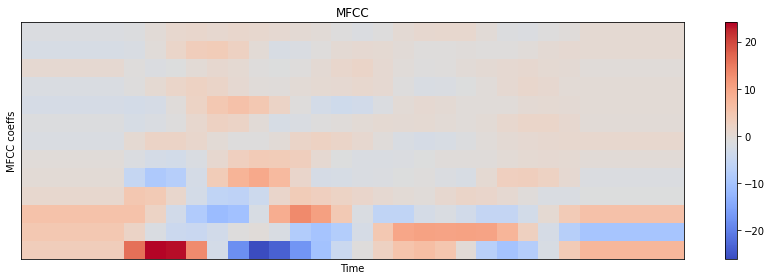

In [16]:
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)  # log_S의 MFCC를 계산

delta2_mfcc = librosa.feature.delta(mfcc, order=2)  # 첫 번째와 두 번째 델타를 계산

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

## 1.3 Spectrogram in 3d

In [27]:
data = [go.Surface(z=spectrogram.T)]
layout = go.Layout(
    title='Specgtrogram of "yes" in 3d',
    scene = dict(
        yaxis = dict(title='Frequencies', range=[min(freqs), max(freqs)]),
        # xaxis = dict(title='Time', range=times),
        xaxis = dict(title='Time', range=[0, len(times)-1]),  # times 배열을 리스트로 변환
        zaxis = dict(title='Log amplitude')
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

## 1.4 Silence removal

In [28]:
ipd.Audio(samples, rate=sample_rate)

In [29]:
samples_cut = samples[4000:13000]
ipd.Audio(samples_cut, rate=sample_rate)

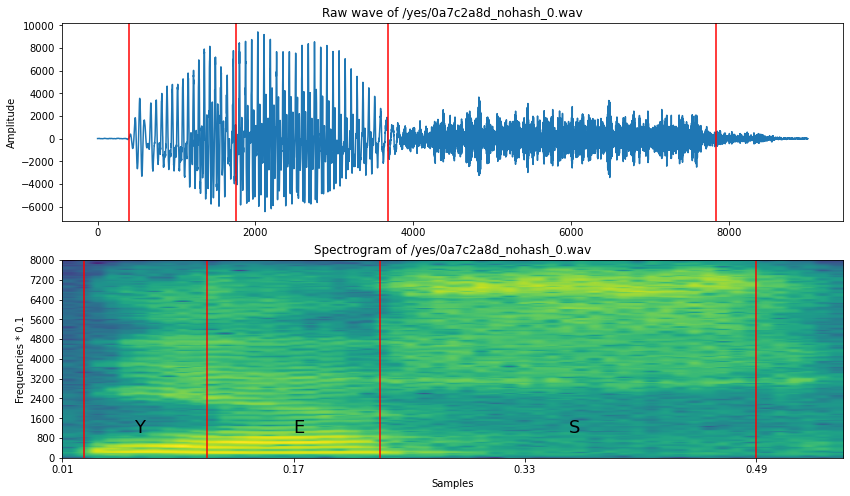

In [30]:
freqs, times, spectrogram_cut = log_specgram(samples_cut, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(samples_cut)

ax2 = fig.add_subplot(212)
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Frequencies * 0.1')
ax2.set_xlabel('Samples')
ax2.imshow(spectrogram_cut.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.text(0.06, 1000, 'Y', fontsize=18)
ax2.text(0.17, 1000, 'E', fontsize=18)
ax2.text(0.36, 1000, 'S', fontsize=18)

xcoords = [0.025, 0.11, 0.23, 0.49]
for xc in xcoords:
    ax1.axvline(x=xc*16000, c='r')
    ax2.axvline(x=xc, c='r')

## 1.5 Resampling - dimensionality reduction

In [31]:
# 주어진 시계열 신호 y와 샘플링 주파수 fs를 사용하여 주파수 영역에서의 신호를 분석하기 위해 FFT (Fast Fourier Transform)를 계산
def custom_fft(y, fs):
    T = 1.0 / fs  # 샘플링 간격
    N = y.shape[0]  # 입력 신호의 샘플 수
    yf = fft(y)  # 시계열 신호의 FFT 결과
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)  # 결과 FFT의 주파수 영역을 나타내는 데 사용되는 주파수 벡터
    vals = 2.0/N * np.abs(yf[0:N//2])  # FFT is simmetrical, so we take just the first half
    # FFT is also complex, to we take just the real part (abs)
    return xf, vals

In [32]:
filename = '/happy/0b09edd3_nohash_0.wav'
new_sample_rate = 8000

sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
resampled = signal.resample(samples, int(new_sample_rate/sample_rate * samples.shape[0]))

In [33]:
ipd.Audio(samples, rate=sample_rate)

In [34]:
ipd.Audio(resampled, rate=new_sample_rate)

거의 차이가 없음!

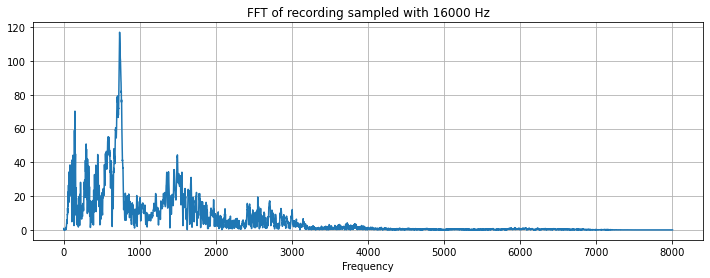

In [35]:
xf, vals = custom_fft(samples, sample_rate)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(sample_rate) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

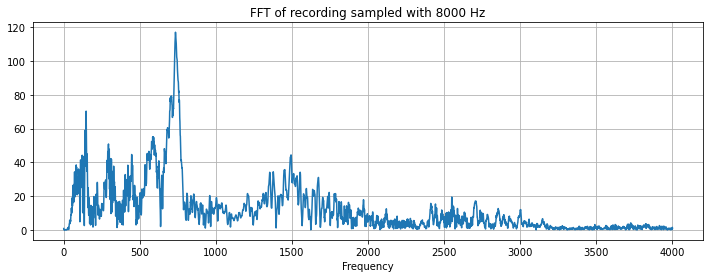

In [36]:
xf, vals = custom_fft(resampled, new_sample_rate)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(new_sample_rate) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

## 1.6 Features extraction steps
1. Resampling
2. VAD
3. Maybe padding with 0 to make signals be equal length
4. Log spectrogram (or MFCC, or PLP)
5. Features normalization with mean and std
6. Stacking of a given number of frames to get temporal information

# 2. Dataset investigation

## 2.1. Number of records

In [37]:
dirs = [f for f in os.listdir(train_audio_path) if isdir(join(train_audio_path, f))]
dirs.sort()
print('Number of labels: ' + str(len(dirs)))

Number of labels: 31


In [39]:
# Calculate
number_of_recordings = []
for direct in dirs:
    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    number_of_recordings.append(len(waves))

# Plot
data = [go.Histogram(x=dirs, y=number_of_recordings)]
trace = go.Bar(
    x=dirs,
    y=number_of_recordings,
    marker=dict(color = number_of_recordings, colorscale='Viridis', showscale=True
    )
)
layout = go.Layout(
    title='Number of recordings in given label',
    xaxis = dict(title='Words'),
    yaxis = dict(title='Number of recordings')
)
py.iplot(go.Figure(data=[trace], layout=layout))

## 2.2 Deeper into recordings

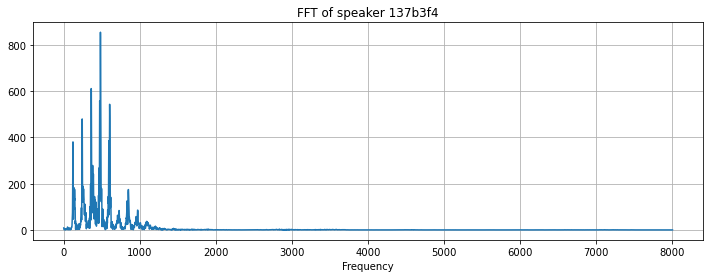

In [40]:
filenames = ['on/004ae714_nohash_0.wav', 'on/0137b3f4_nohash_0.wav']
for filename in filenames:
    sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
    xf, vals = custom_fft(samples, sample_rate)
    plt.figure(figsize=(12, 4))
    plt.title('FFT of speaker ' + filename[4:11])
    plt.plot(xf, vals)
    plt.xlabel('Frequency')
    plt.grid()
    plt.show()

In [41]:
print('Speaker ' + filenames[0][4:11])
ipd.Audio(join(train_audio_path, filenames[0]))

Speaker 04ae714


In [42]:
print('Speaker ' + filenames[0][4:11])
ipd.Audio(join(train_audio_path, filenames[1]))

Speaker 04ae714


In [43]:
filename = '/yes/01bb6a2a_nohash_1.wav'
sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
freqs, times, spectrogram = log_specgram(samples, sample_rate)

plt.figure(figsize=(10, 7))
plt.title('Spectrogram of ' + filename)
plt.ylabel('Freqs')
plt.xlabel('Time')
plt.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
plt.yticks(freqs[::16])
plt.xticks(times[::16])
plt.show()

## 2.3. Recordings length

In [44]:
# train_audio_path에 있는 모든 파일 중에서 1초 미만인 파일의 개수
num_of_shorter = 0
for direct in dirs:
    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + direct + '/' + wav)
        if samples.shape[0] < sample_rate:
            num_of_shorter += 1
print('Number of recordings shorter than 1 second: ' + str(num_of_shorter))

<ipython-input-44-b5f9e3bbcc58>:6: WavFileWarning:

Chunk (non-data) not understood, skipping it.



Number of recordings shorter than 1 second: 6469


## 2.4 Mean spectrograms and FFT

['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes']


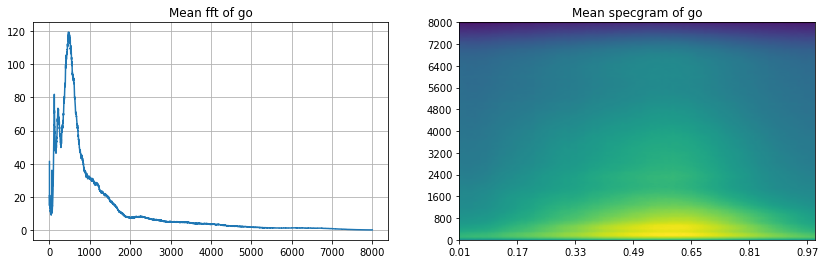

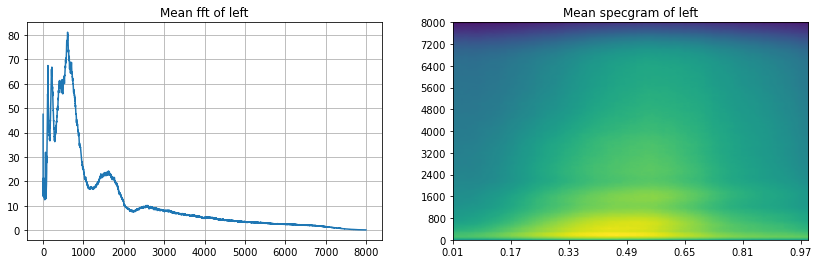

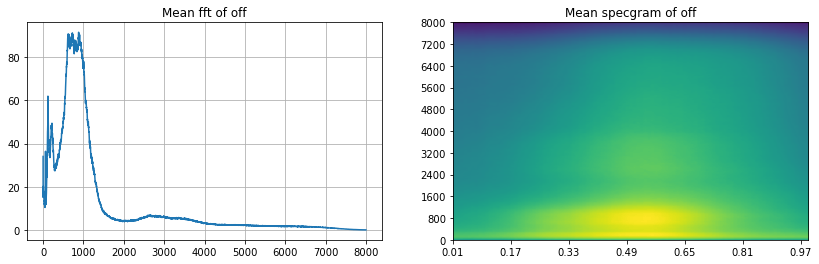

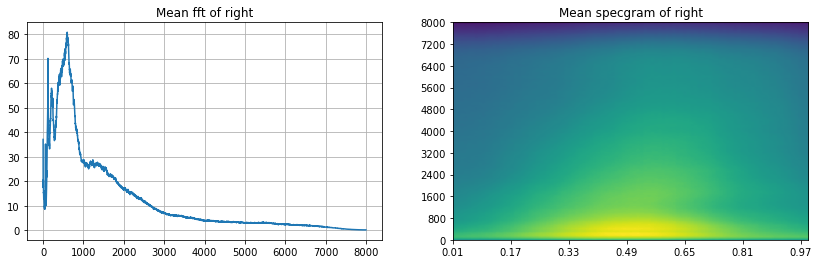

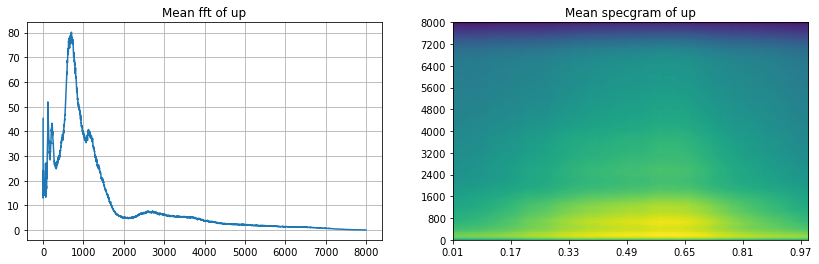

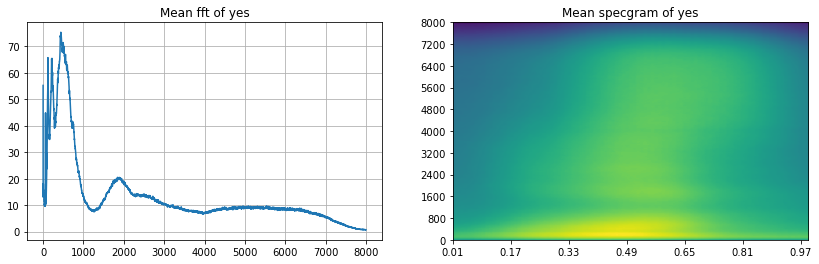

In [45]:
to_keep = 'yes no up down left right on off stop go'.split()
dirs = [d for d in dirs if d in to_keep]

print(dirs)

for direct in dirs:
    vals_all = []
    spec_all = []

    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + direct + '/' + wav)
        if samples.shape[0] != 16000:
            continue
        xf, vals = custom_fft(samples, 16000)
        vals_all.append(vals)
        freqs, times, spec = log_specgram(samples, 16000)
        spec_all.append(spec)

    plt.figure(figsize=(14, 4))
    plt.subplot(121)
    plt.title('Mean fft of ' + direct)
    plt.plot(np.mean(np.array(vals_all), axis=0))
    plt.grid()
    plt.subplot(122)
    plt.title('Mean specgram of ' + direct)
    plt.imshow(np.mean(np.array(spec_all), axis=0).T, aspect='auto', origin='lower', 
               extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    plt.yticks(freqs[::16])
    plt.xticks(times[::16])
    plt.show()

## 2.5. Gaussian Mixtures modeling
- 각 단어의 평균 FFT가 다르다는 것을 확인하였다. 
- 각 FFT를 가우시안 분포의 혼합으로 모델링 할 수 있으나 일부 단어는 FFT에서 거의 동일하게 보이며, 예를 들어 stop과 up은 비슷해 보인다. 
- 그러나 스펙트로그램을 보면 여전히 구별이 가능하다. stop의 경우 고주파수는 낮은 주파수보다 앞서 나타나기 때문이다.
- 그래서 시간적인 요소도 필요. Kaldi 라이브러리를 사용하여 GMMs로 단어(또는 단어의 작은 부분)를 모델링하고 Hidden Markov Models로 시간적 종속성을 모델링 할 수 있다.
- 간단한 GMMs를 사용하여 각 단어를 모델링하여 어떤 것을 모델링 할 수 있고 단어를 구별하는 것이 얼마나 어려운지 확인 할 수 있다.
- Scikit-learn을 사용할 수 있지만 여기에서는 직관적이지 않고 매우 오래 걸리므로 일단 이 아이디어를 포기한다.

## 2.6. Frequency components across the words

In [46]:
def violinplot_frequency(dirs, freq_ind):  # freq_ind : 관심 주파수 인덱스

    spec_all = []  # Contain spectrograms
    ind = 0
    for direct in dirs:  # dirs : 단어 목록이 들어 있는 리스트
        spec_all.append([])

        waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
        for wav in waves[:100]:
            sample_rate, samples = wavfile.read(train_audio_path + direct + '/' + wav)
            freqs, times, spec = log_specgram(samples, sample_rate)
            spec_all[ind].extend(spec[:, freq_ind])
        ind += 1

    # Different lengths = different num of frames. Make number equal
    # 모든 단어의 스펙트로그램 길이가 다르므로, 가장 작은 스펙트로그램 길이로 모든 스펙트로그램을 자르고, 'spec_all' 배열에 저장
    minimum = min([len(spec) for spec in spec_all])
    spec_all = np.array([spec[:minimum] for spec in spec_all])

    plt.figure(figsize=(13,7))
    plt.title('Frequency ' + str(freqs[freq_ind]) + ' Hz')
    plt.ylabel('Amount of frequency in a word')
    plt.xlabel('Words')
    sns.violinplot(data=pd.DataFrame(spec_all.T, columns=dirs))
    plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:82: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



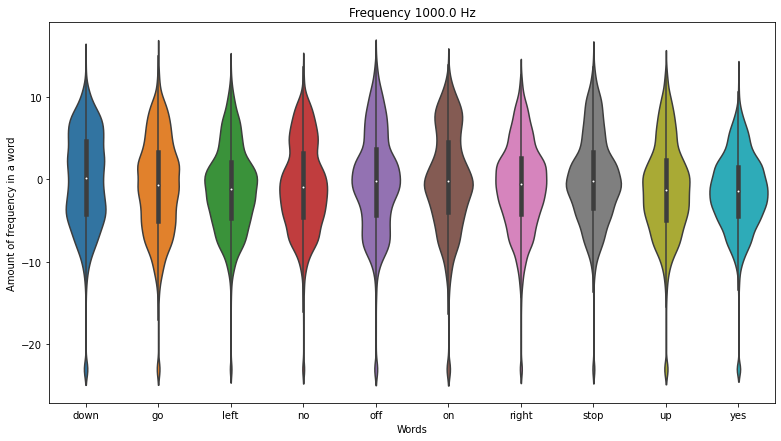

In [47]:
violinplot_frequency(dirs, 20)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:82: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



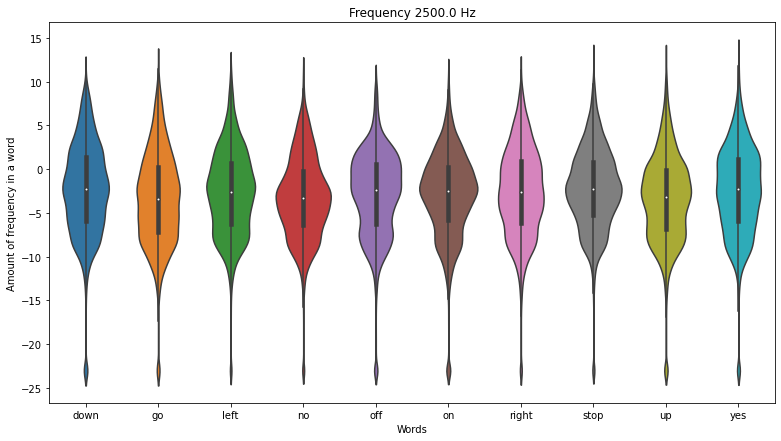

In [48]:
violinplot_frequency(dirs, 50)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:82: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



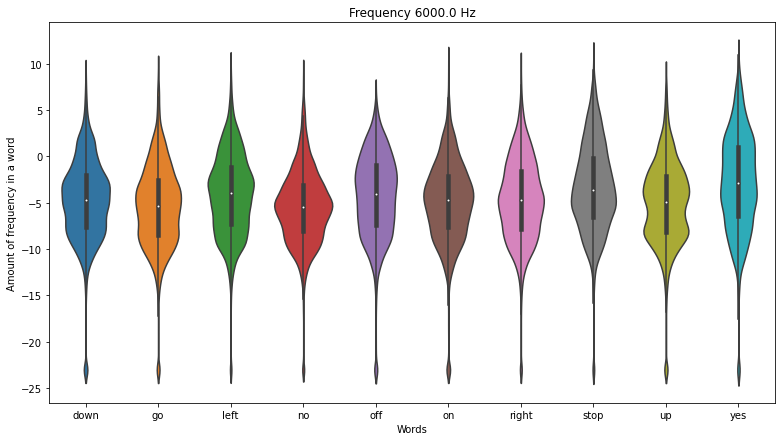

In [49]:
violinplot_frequency(dirs, 120)

## 2.7 Anomaly detection

In [50]:
fft_all = []
names = []
for direct in dirs:
    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + direct + '/' + wav)
        #  # 주어진 음성 샘플(samples)의 길이가 샘플링 레이트(sample_rate)와 같지 않은 경우, 샘플의 길이를 늘려주는 코드
        if samples.shape[0] != sample_rate:
            samples = np.append(samples, np.zeros((sample_rate - samples.shape[0], ))) 
        x, val = custom_fft(samples, sample_rate)
        fft_all.append(val)
        names.append(direct + '/' + wav)

fft_all = np.array(fft_all)

# Normalization
fft_all = (fft_all - np.mean(fft_all, axis=0)) / np.std(fft_all, axis=0)

# Dim reduction
pca = PCA(n_components=3)
fft_all = pca.fit_transform(fft_all)  # fft_all 리스트에 있는 FFT 값들을 3차원으로 축소

In [51]:
def interactive_3d_plot(data, names):
    scatt = go.Scatter3d(x=data[:, 0], y=data[:, 1], z=data[:, 2], mode='markers', text=names)
    data = go.Data([scatt])
    layout = go.Layout(title="Anomaly detection")
    figure = go.Figure(data=data, layout=layout)
    py.iplot(figure)
    
interactive_3d_plot(fft_all, names)

C:\ProgramData\Anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:31: DeprecationWarning:

plotly.graph_objs.Data is deprecated.
Please replace it with a list or tuple of instances of the following types
  - plotly.graph_objs.Scatter
  - plotly.graph_objs.Bar
  - plotly.graph_objs.Area
  - plotly.graph_objs.Histogram
  - etc.




In [52]:
print('Recording go/0487ba9b_nohash_0.wav')
ipd.Audio(join(train_audio_path, 'go/0487ba9b_nohash_0.wav'))

Recording go/0487ba9b_nohash_0.wav


In [53]:
print('Recording yes/e4b02540_nohash_0.wav')
ipd.Audio(join(train_audio_path, 'yes/e4b02540_nohash_0.wav'))

Recording yes/e4b02540_nohash_0.wav


In [54]:
print('Recording seven/e4b02540_nohash_0.wav')
ipd.Audio(join(train_audio_path, 'seven/b1114e4f_nohash_0.wav'))

Recording seven/e4b02540_nohash_0.wav
